# Soil Moisture Analysis Using ESA CCI SM Data for 2021 (v07.1 COMBINED Product)

### Prepared by: Khizer Zakir
### Date: 04-10-2024

This document provides the steps and methods used to analyze soil moisture over the Iberian Peninsula and D-A-CH region, as well as to create global seasonal maps using data from the ESA CCI SM v07.1 COMBINED product. The workflow covers three tasks:

- **Task 1**: Download all soil moisture data from the year 2021.
- **Task 2**: Extract regional data for Iberia and D-A-CH, and compute daily mean soil moisture values for these regions.
- **Task 3**: Generate seasonal maps of mean global soil moisture.

### Prerequisites
Before proceeding, ensure you have the following Python libraries installed:
```bash
pip install xarray numpy pandas matplotlib cartopy netCDF4 [this is a dependency]


## Task 1: Downloading ESA CCI SM v07.1 COMBINED Data

The ESA CCI Soil Moisture data for the year 2021 (v07.1 COMBINED product) is available for download through the CEDA Archive. You will need to download the NetCDF files for all days of 2021. 

***Hint*** - You can bulk download all the files together. 

Once downloaded, store the files in a directory for further processing.



## Task 2: Extracting Data for Iberia and D-A-CH Regions and Calculating Daily Mean Soil Moisture

**Step 1**: Define Region Boundaries

We are interested in two regions:

**Iberian Peninsula:**

`Latitude: 34.4 to 45.3`
`Longitude: -9.4 to 5.6`

**D-A-CH (Germany-Austria-Switzerland):**

`Latitude: 45.8 to 55.1`
`Longitude: 5.9 to 17.2`


***Some part of the code is inspired from TUWIEN github*** - Reference at the end

In [1]:
# Import libraries / warnings

import os  # Provides functions to interact with the operating system (e.g., file and directory management)
from pathlib import Path  # Offers an object-oriented approach to handle filesystem paths
import matplotlib.pyplot as plt  # Used for creating static, animated, and interactive visualizations in Python
import matplotlib.dates as mdates # for dates and month locator
import cartopy  # Provides tools for cartographic projections and geospatial data visualization
import cartopy.crs as ccrs  # Used to handle coordinate reference systems in Cartopy maps
import xarray as xr  # Facilitates working with labeled multi-dimensional arrays, particularly in the context of climate data
import shutil  # Allows high-level operations on files and collections of files, such as copying and removing files
import pandas as pd  # Provides powerful data structures like DataFrames for data manipulation and analysis
import numpy as np  # Supports large, multi-dimensional arrays and matrices, along with a collection of mathematical functions
from matplotlib.lines import (
    Line2D,
)  # Used to create and customize line objects in Matplotlib plots
import matplotlib.colors as colors  # Manages color maps and normalizing data values to colors in Matplotlib
import warnings  # Provides a way to issue warning messages and control their visibility
from tqdm import tqdm  # for the progress bar
import time 

warnings.filterwarnings("ignore")  # Suppresses warnings from appearing in the output

%matplotlib inline

Color Scheme for plotting - Code Taken from TUWIEN github page

In [2]:
CM_SM = colors.LinearSegmentedColormap.from_list(
    "BrownBlue",
    np.array(
        [
            [134, 80, 16],
            [164, 117, 13],
            [219, 190, 24],
            [250, 249, 156],
            [144, 202, 240],
            [4, 145, 251],
            [8, 83, 211],
            [13, 37, 161],
        ]
    )
    / 255.0,
)

**Step 2:** Load and Process Data

We use the xarray package to load the daily soil moisture data from the NetCDF files, filter the data over the specified regions, and calculate daily mean soil moisture for each region.
 ```bash
 BBOXES = {
    "Iberia": [(34.4, 45.3), (-9.4, 5.6)],  # Latitude and Longitude (min/max)
    "D-A-CH": [(45.8, 55.1), (5.9, 17.2)],
} - Global Variable


In [3]:
BBOXES = {
    "Iberia": [(34.4, 45.3), (-9.4, 5.6)],  # Latitude and Longitude (min/max)
    "D-A-CH": [(45.8, 55.1), (5.9, 17.2)],
}

def merge_netcdf_files(data_dir, output_dir, study_areas):
    """
    Merges NetCDF files and applies spatial filtering based on the bounding box of multiple study areas.

    :param data_dir: Path to the directory where the NetCDF files are stored.
    :param output_dir: Path to the directory where the merged NetCDF files will be saved.
    :param study_areas: List of chosen study areas (e.g., ['Iberia', 'D-A-CH']).
    """
    for study_area in study_areas:
        bbox = BBOXES[study_area]
        merged_netcdf_file = os.path.join(output_dir, f"{study_area}_merged_daily_soil_moisture.nc")
        filelist = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.nc')])

        print(f"Processing for study area: {study_area}")
        print(f"Found {len(filelist)} NetCDF files in the directory. Merging for {study_area}...")

        if not os.path.isfile(merged_netcdf_file):
            ds_list = []

            for file in tqdm(filelist, desc=f"Processing NetCDF files for {study_area}"):
                ds = xr.open_dataset(file)
                ds_filtered = filter_by_bbox(ds, bbox)
                ds_list.append(ds_filtered)

                    # Print preocess message
            print(f"Concatenating the filtered datasets for {study_area}...")

            # time of process
            start_time = time.time()

            ds_merged = xr.concat(ds_list, dim='time')

            end_time = time.time()
            elapsed_time = end_time - start_time

            print(f"Merged dataset shape: {ds_merged['sm'].shape}")
            print(f"Concatenation took {elapsed_time:.2f} seconds.")

            # Save the merged dataset for this study area
            ds_merged.to_netcdf(merged_netcdf_file)

            print(f"Preprocessing done for {study_area}. NetCDF stack saved at: {merged_netcdf_file}\n")
        else:
            print(f"No preprocessing required for {study_area}. NetCDF stack already exists at: {merged_netcdf_file}\n")

def filter_by_bbox(ds, bbox):
    """
    Filters the dataset based on the bounding box of the study area.

    :param ds: The full dataset.
    :param bbox: Bounding box coordinates for filtering.
    :return: Dataset filtered by the bounding box.
    """
    lat_min, lat_max = bbox[0]
    lon_min, lon_max = bbox[1]

    # Extract the latitude and longitude values from the dataset
    lats = ds['lat'].values
    lons = ds['lon'].values

    # Use np.where() to find indices that are within the bounding box
    lat_indices = np.where((lats >= lat_min) & (lats <= lat_max))[0]
    lon_indices = np.where((lons >= lon_min) & (lons <= lon_max))[0]

    # Subset the dataset using the indices from np.where
    ds_filtered = ds.isel(lat=lat_indices, lon=lon_indices)

    return ds_filtered

def extract_regional_mean_time_series(output_dir, study_areas):
    """
    Extracts the regional mean time series of soil moisture data for specified study areas.
    
    :param output_dir: Path to the directory where merged NetCDF files are stored.
    :param study_areas: List of study areas (e.g., ['Iberia', 'D-A-CH']).
    :return: A tuple of time series for each study area (ts_aoi1, ts_aoi2).
    """
    ts_aoi1 = None
    ts_aoi2 = None

    # Find all merged NetCDF files in the output directory
    merged_files = [f for f in os.listdir(output_dir) if f.endswith('.nc')]

    for study_area in study_areas:
        for merged_file in merged_files:
            merged_netcdf_file = os.path.join(output_dir, merged_file)

            # Extract region name from the file name
            region_name = merged_file.split('_')[0]

            if region_name.lower() == study_area.lower():
                print(f"Processing time series for: {region_name}")

                # Open the merged dataset
                ds = xr.open_dataset(merged_netcdf_file)

                # Compute regional mean for each time step
                regional_mean = ds['sm'].mean(dim=['lat', 'lon'])
                print(f"Regional mean shape for {region_name}: {regional_mean.shape}")

                # Convert to pandas time series
                ts_aoi = regional_mean.to_pandas()

                # Assign to appropriate variable based on study area
                if study_area == "Iberia":
                    ts_aoi1 = ts_aoi
                elif study_area == "D-A-CH":
                    ts_aoi2 = ts_aoi

                # Break loop when time series for the region is found
                break
        
        if ts_aoi is None:
            print(f"Warning: No time series found for study area {study_area}")

    return ts_aoi1, ts_aoi2

**Step 3:** Plot Daily Mean Soil Moisture for Iberia and D-A-CH

Once we have the daily mean values for each region, we can create a time series plot 

***optional*** - an annual mean map just for understanding

In [172]:

## ChatGPT helped for beautification

def plot_time_series(ts_iber, ts_dach):
    """
    Plots a twin time series for Iberia and D-A-CH with improved aesthetics,
    including minor ticks for daily granularity.
    """

    # Create a wider plot for better visibility of daily changes
    fig, ax = plt.subplots(figsize=(18, 8))

    # twin plots
    ax.plot(ts_iber.index, ts_iber, label="Iberia", color="blue", linewidth=0.8)
    ax.plot(ts_dach.index, ts_dach, label="D-A-CH", color="green", linewidth=0.8, linestyle='--')
    
    # Set x-axis major locator to display all months
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
    # Set x-axis minor locator for daily ticks
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))  # Adjust interval as needed for spacing
    
    # Set labels and title
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Soil Moisture (m³/m³)", fontsize=12)
    ax.set_title("Soil Moisture Regional Mean Time Series for Iberia and D-A-CH", fontsize=16)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Enable the minor grid to improve readability
    ax.grid(which='both', linestyle='--', linewidth=0.4)

    # Add legend
    ax.legend(title="Regions", fontsize=10)

    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()

def create_annual_mean_maps(output_dir, study_areas):
    """
    Creates annual mean soil moisture maps for specified study areas.
    
    :param output_dir: Path to the directory where merged NetCDF files are stored.
    :param study_areas: List of study areas (e.g., ['Iberia', 'D-A-CH']).
    """
    merged_files = [f for f in os.listdir(output_dir) if f.endswith('.nc')]

    fig, axs = plt.subplots(1, len(study_areas), figsize=(15, 7))  # 1xN subplot for maps

    for idx, study_area in enumerate(study_areas):
        for merged_file in merged_files:
            merged_netcdf_file = os.path.join(output_dir, merged_file)
            region_name = merged_file.split('_')[0]

            if region_name.lower() == study_area.lower():
                print(f"Processing annual mean map for: {region_name}")

                # Open dataset
                ds = xr.open_dataset(merged_netcdf_file)

                # Calculate the annual mean for the region
                annual_mean = ds['sm'].groupby('time.year').mean(dim='time')

                # Get latitude and longitude bounds for the study area
                lat_bounds = BBOXES[study_area][0]
                lon_bounds = BBOXES[study_area][1]

                # Plot the map for the respective region
                im = axs[idx].imshow(annual_mean.mean(dim='year'), 
                                     vmin=0, 
                                     vmax=0.5, 
                                     cmap=CM_SM, 
                                     extent=[lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]],
                                     aspect='auto')  

                axs[idx].set_title(f"Annual Mean Soil Moisture - {region_name}", fontsize=14)
                axs[idx].set_xlabel("Longitude", fontsize=12)
                axs[idx].set_ylabel("Latitude", fontsize=12)
                axs[idx].grid(True)

                # Break loop when the map is plotted for the region
                break

    cbar_ax = fig.colorbar(im, ax=axs, orientation='horizontal', extend="both")
    cbar_ax.set_label('Soil Moisture (m³/m³)') # volume of water per total volume

    # Manually adjust colorbar position
    cbar_ax.ax.set_position([0.25, -0.3, 0.5, 0.2])  # [left, bottom, width, height]

    plt.tight_layout()
    plt.show()

#### Processing **step 2** functions 

In [5]:
# setting up directories

data_dir = "./v07.1/2021"
os.makedirs(data_dir, exist_ok=True)
output_dir = os.path.join(data_dir, "output")
os.makedirs(output_dir, exist_ok=True)
study_areas = ['Iberia', 'D-A-CH']

# Merging NetCDF files
merge_netcdf_files(data_dir, output_dir, study_areas)
# extracting time series
ts_iber, ts_dach = extract_regional_mean_time_series(output_dir, study_areas)

Processing for study area: Iberia
Found 365 NetCDF files in the directory. Merging for Iberia...


Processing NetCDF files for Iberia: 100%|██████████| 365/365 [00:11<00:00, 30.62it/s]


Concatenating the filtered datasets for Iberia...
Merged dataset shape: (365, 43, 60)
Concatenation took 37.29 seconds.
Preprocessing done for Iberia. NetCDF stack saved at: ./v07.1/2021\output\Iberia_merged_daily_soil_moisture.nc

Processing for study area: D-A-CH
Found 365 NetCDF files in the directory. Merging for D-A-CH...


Processing NetCDF files for D-A-CH: 100%|██████████| 365/365 [00:11<00:00, 31.37it/s]


Concatenating the filtered datasets for D-A-CH...
Merged dataset shape: (365, 37, 45)
Concatenation took 37.14 seconds.
Preprocessing done for D-A-CH. NetCDF stack saved at: ./v07.1/2021\output\D-A-CH_merged_daily_soil_moisture.nc

Processing time series for: Iberia
Regional mean shape for Iberia: (365,)
Processing time series for: D-A-CH
Regional mean shape for D-A-CH: (365,)


#### Processing **step 3** functions 

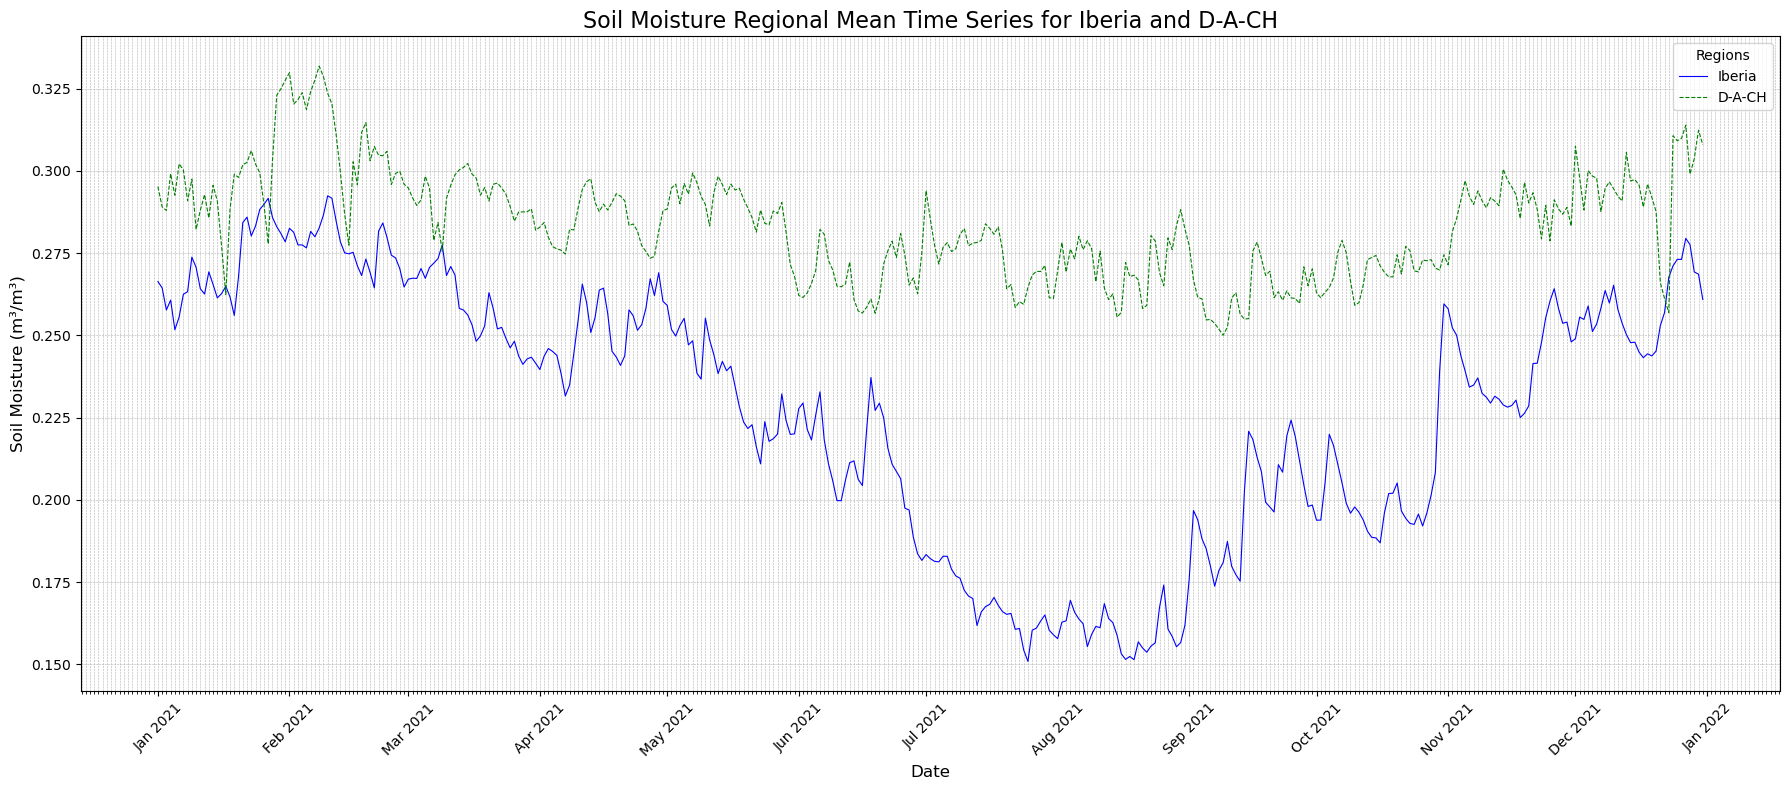

Processing annual mean map for: Iberia
Processing annual mean map for: D-A-CH


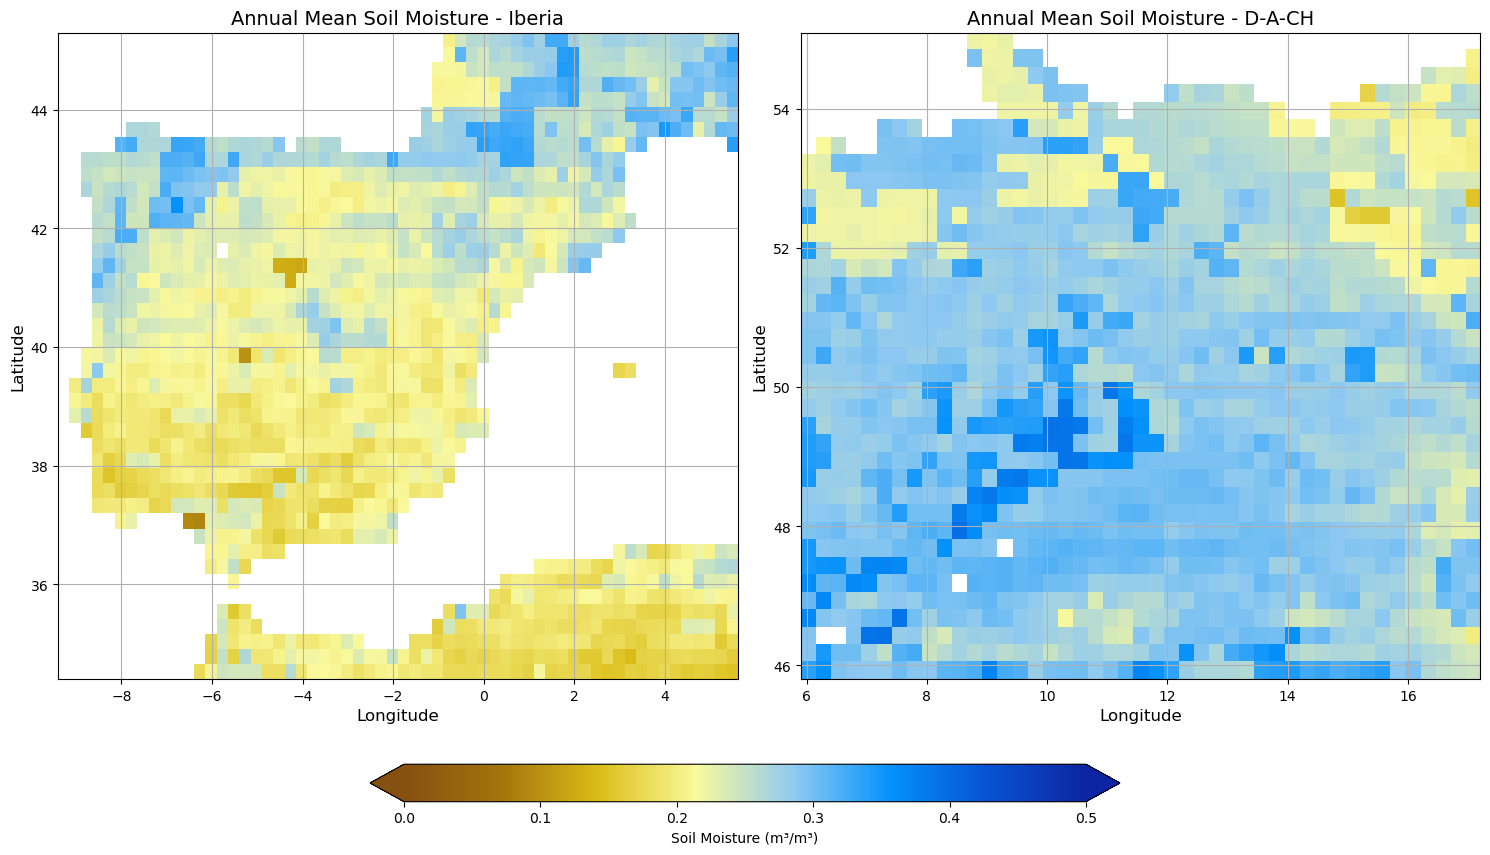

In [173]:

# time series plot
plot_time_series(ts_iber, ts_dach)

# annual mean maps plot
create_annual_mean_maps(output_dir, study_areas)

![The major difference between the 2 time series](./output1.png)
*The major difference between the 2 time series*

## Task 3: Plotting Seasonal Global Soil Moisture Maps

**Step 1:** Define Meteorological Seasons

We define the meteorological seasons as follows: with reference to: https://ismn.earth/en/about-us-test/c3s/ 

- ***Spring: March 1 to May 31*** (MAM)
- ***Summer: June 1 to August 31*** (JJA)
- ***Autumn: September 1 to November 30*** (SON)
- ***Winter: December 1 to February 28 (29 for leap years)*** (DJF)

**Step 2:** Calculate Seasonal Mean Soil Moisture

Using the same global dataset, we compute seasonal means by averaging the daily data over the appropriate date ranges.

In [162]:
def calculate_seasonal_means(data_dir):
    """
    Calculate seasonal mean soil moisture from NetCDF files in the given directory.

    Parameters:
    data_dir (str): Directory containing the NetCDF files.

    Returns:
    dict: A dictionary with seasonal means for 'MAM', 'JJA', 'SON', and 'DJF'.
    """
    # Initialize an empty list to store datasets
    datasets = []

    # Loop over the files and load the datasets
    for nc_file in os.listdir(data_dir):
        if nc_file.endswith('.nc'):
            # Open the file and append it to the list
            ds = xr.open_dataset(os.path.join(data_dir, nc_file))
            datasets.append(ds)

    # Concatenate all datasets along the time dimension
    combined_ds = xr.concat(datasets, dim='time')

    # Group by season and calculate the mean for each season
    seasonal_mean = combined_ds.sm.groupby('time.season').mean(dim='time')

    # Extract seasonal means - 
    # ref: https://ismn.earth/en/about-us-test/c3s/ 
    seasonal_means = {
        'MAM': seasonal_mean.sel(season='MAM'),
        'JJA': seasonal_mean.sel(season='JJA'),
        'SON': seasonal_mean.sel(season='SON'),
        'DJF': seasonal_mean.sel(season='DJF')
    }

    return seasonal_means, combined_ds

def print_seasonal_means(seasonal_means):
    """
    Print the seasonal means in a readable format.

    Parameters:
    seasonal_means (dict): A dictionary with seasonal means for 'MAM', 'JJA', 'SON', and 'DJF'.
    """
    print("Seasonal Mean Soil Moisture (m³/m³):")
    for season, mean in seasonal_means.items():
        print(f"{season}: {mean.mean().values:.4f} (Mean), Min: {mean.min().values:.4f}, Max: {mean.max().values:.4f}")



#### Processing **step 2** functions 

In [108]:

# Calculate seasonal means
seasonal_means, combined_ds = calculate_seasonal_means(data_dir)

# Print seasonal means
print_seasonal_means(seasonal_means)


Seasonal Mean Soil Moisture (m³/m³):
MAM: 0.2106 (Mean), Min: 0.0000, Max: 0.7631
JJA: 0.2035 (Mean), Min: 0.0000, Max: 0.5251
SON: 0.2116 (Mean), Min: 0.0201, Max: 0.5809
DJF: 0.2075 (Mean), Min: 0.0000, Max: 0.8666


**Step 3:** Plot the Seasonal Maps

2D - Plot the seasonal maps for each of the four seasons. The seasonal maps are the mean soil moisture maps for the whole globe. 

In [ ]:
def plot_seasonal_means(seasonal_means, combined_ds):
    """
    Plot seasonal mean soil moisture for the provided seasonal means.

    Parameters:
    seasonal_means (dict): A dictionary with seasonal means for 'MAM', 'JJA', 'SON', and 'DJF'.
    combined_ds (xarray.Dataset): The combined dataset for plotting extents.
    """
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    # colorbar based on soil moisture range
    vmin, vmax = seasonal_means['MAM'].min().values, seasonal_means['MAM'].max().values

    # Plot the seasonal means
    titles = ['Spring (MAM)', 'Summer (JJA)', 'Autumn (SON)', 'Winter (DJF)']
    seasons = ['MAM', 'JJA', 'SON', 'DJF']
    
    for i, ax in enumerate(axs.flat):
        im = ax.imshow(seasonal_means[seasons[i]].values, cmap='RdBu_r', 
                       extent=(combined_ds.lon.min().values, combined_ds.lon.max().values, 
                               combined_ds.lat.min().values, combined_ds.lat.max().values), 
                       vmin=vmin, vmax=vmax)
        ax.set_title(titles[i])
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.grid(True)

        # colorbar to each subplot
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=1, pad=0.09, extend="both")
        cbar.set_label('Volumetric Soil Moisture (m³/m³)')

    fig.suptitle('Seasonal Soil Moisture Content Means (2021)', fontsize=16)

    # [left, bottom, right, top]

    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.9])

    plt.show()

#### Processing **step 3** functions 

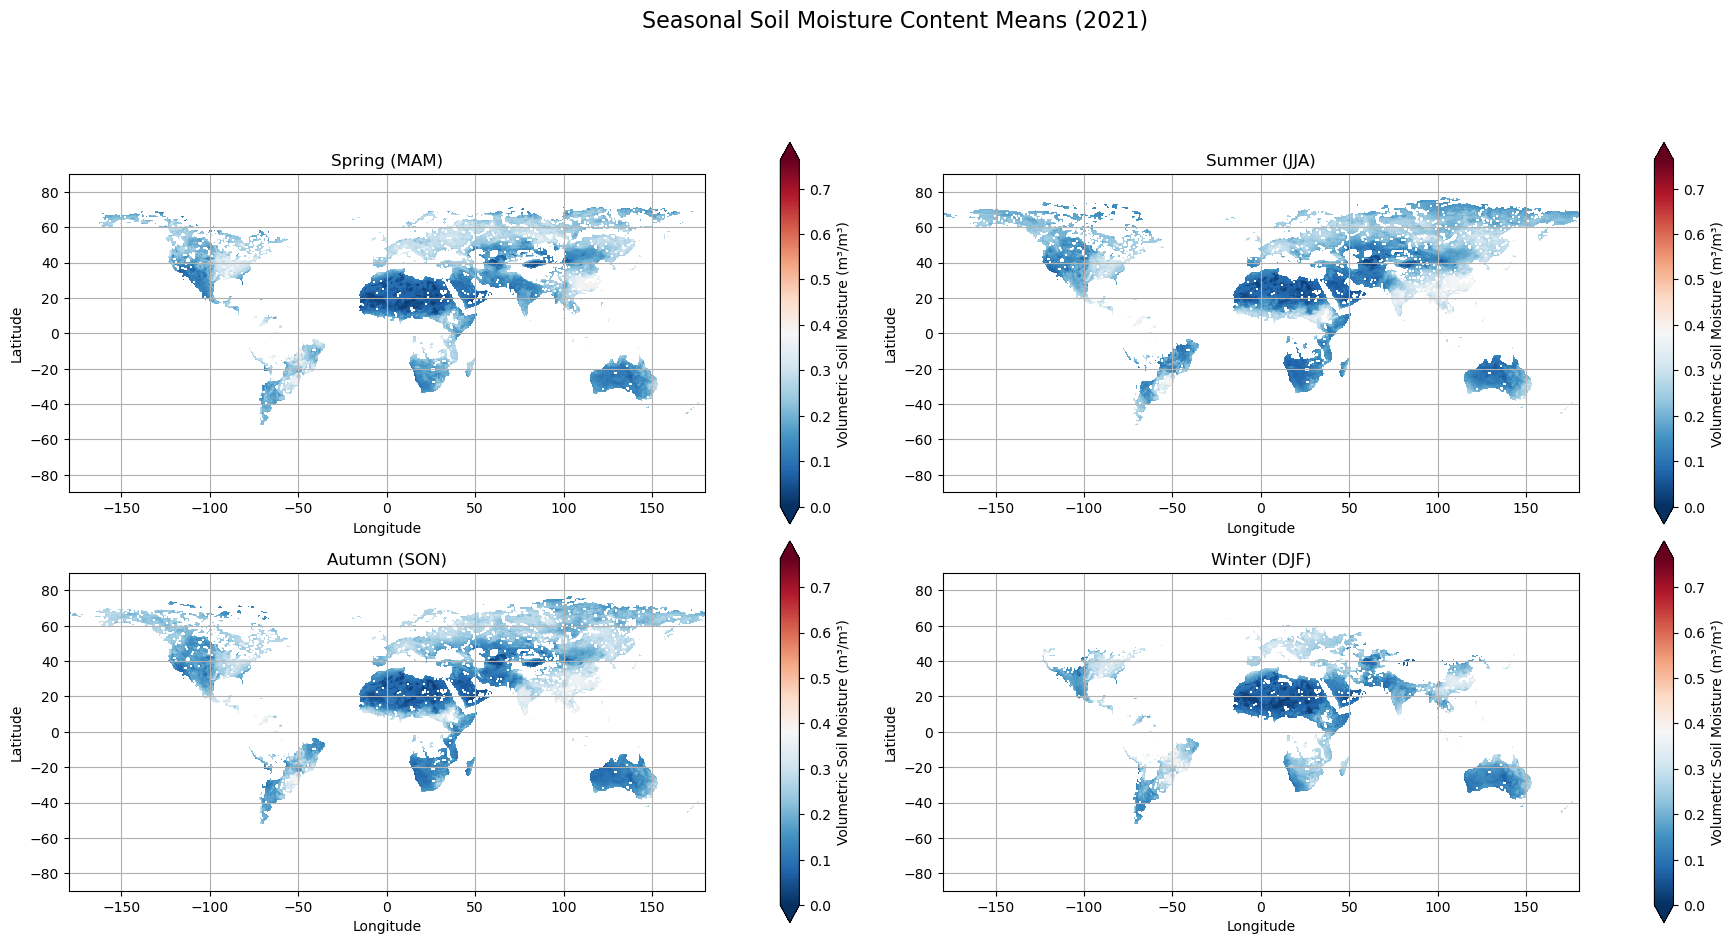

In [163]:
# Plot the seasonal means
plot_seasonal_means(seasonal_means, combined_ds)

## Conclusion

This analysis provided insights into soil moisture patterns over the Iberian Peninsula and the D-A-CH region for the year 2021. Additionally, global seasonal maps of soil moisture were created to visualize spatial patterns across spring, summer, autumn, and winter.

## References

### Dataset
- **ESA Soil Moisture Climate Change Initiative (Soil_Moisture_cci): COMBINED product, Version 07.1**  
  Dorigo, W.; Preimesberger, W.; Moesinger, L.; Pasik, A.; Scanlon, T.; Hahn, S.; Van der Schalie, R.; Van der Vliet, M.; De Jeu, R.; Kidd, R.; Rodriguez-Fernandez, N.; Hirschi, M. (2023): ESA Soil Moisture Climate Change Initiative (Soil_Moisture_cci): COMBINED product, Version 07.1. NERC EDS Centre for Environmental Data Analysis, date of citation. [https://catalogue.ceda.ac.uk/uuid/c7e974411cfe4cf99cb077f7cb4d75d4/](https://catalogue.ceda.ac.uk/uuid/c7e974411cfe4cf99cb077f7cb4d75d4/)

### Packages and Libraries Used
- [Matplotlib Documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html#matplotlib.pyplot.show)
© Copyright 2002–2012 John Hunter, Darren Dale, Eric Firing, Michael Droettboom and the Matplotlib development team; 2012–2024 The Matplotlib development team. 
- [NumPy Documentation](https://numpy.org/doc/stable/reference/generated/numpy.random.seed.html)
- {Xarray Documentation](https://docs.xarray.dev/en/stable/index.html)
© Copyright 2014-2024, xarray Developers.
- Pandas, Cartopy and others

### Tutorials

- [C3S - SM Tutorials - TU WIEN](https://github.com/TUW-GEO/c3s_sm-tutorials)
- [Calculating Seasonal Averages - Xarray](https://docs.xarray.dev/en/stable/examples/monthly-means.html)